## 2. Recommender System for Amazon Products

We are building a recommender system for electronic products. We are working on Amazon Product Reviews dataset from Kaggle (https://www.kaggle.com/saurav9786/amazon-product-reviews). The attributes of this dataset are: user id, product id, rating (1-5) and timestamp.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
import seaborn as sns
import random 
from surprise import accuracy,Reader,Dataset
from surprise.accuracy import rmse
from surprise import SVD,SVDpp,NMF,CoClustering,KNNBaseline,KNNWithZScore,KNNBasic,KNNWithMeans
from surprise.model_selection import train_test_split,GridSearchCV

In [8]:
data=pd.read_csv('ratings_electronics.csv',names=['user_id','product_id','rating','timestamp'])

In [9]:
data

,user_id,product_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
...,...,...,...,...
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824478,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200


In [10]:
del data['timestamp']

In [11]:
data

,user_id,product_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0
...,...,...,...
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0
7824478,A322MDK0M89RHN,BT008UKTMW,5.0
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0


In [12]:
data.describe()

,rating
count,7.824482e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


1. Explore the data set and answer the following questions

    (a) How many unique users/products are there?

In [13]:
len(data.user_id.unique())

4201696

In [14]:
len(data.product_id.unique())

476002

In [15]:
data.rating.unique()

array([5., 1., 3., 2., 4.])

(b) What is the distribution of the ratings? (display an histogram).

In [16]:
counts=data.rating.value_counts()

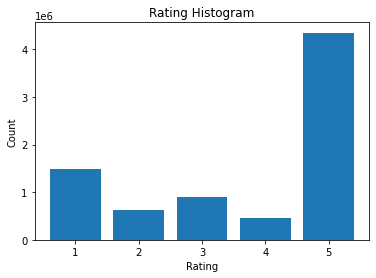

In [17]:
plt.xlabel('Rating')
plt.ylabel('Count')
plt.bar(data.rating.unique(),counts)
plt.title('Rating Histogram')
plt.show()

In [18]:
product_ratings=data.groupby(by='product_id')['rating'].mean().sort_values(ascending=False)

In [19]:
product_ratings

product_id
0132793040    5.0
B004SGH244    5.0
B004SQBRRM    5.0
B004SQC6O0    5.0
B004SQE6YI    5.0
             ... 
B0001FC5IE    1.0
B00465T6KK    1.0
B001W1X0LW    1.0
B0069ZWXLE    1.0
B000TFNDKK    1.0
Name: rating, Length: 476002, dtype: float64

(c) What is the mean number of ratings per user?

In [20]:
rating_per_user = data.groupby(by='user_id')['rating'].count().sort_values(ascending=False)

In [21]:
rating_per_user

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A2HRB8UOXH92SQ      1
A2HRBA4HO2E4GU      1
A2HRBCM00IDK56      1
A2HRBEBDTIB8MT      1
AZZZY1W55XHZR       1
Name: rating, Length: 4201696, dtype: int64

(d) What are the 20 most popular items (items that have received the highest number
of ratings)?

In [22]:
product_ratings_count=data.groupby(by='product_id')['rating'].count().sort_values(ascending=False)[:20]

In [23]:
product_ratings_count[:20]

product_id
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
B003ELYQGG    11617
B003ES5ZUU    10276
B007R5YDYA     9907
B00622AG6S     9823
B0002L5R78     9487
B008OHNZI0     8966
B003LR7ME6     8840
B000LRMS66     8715
B009SYZ8OC     8370
B00BGA9WK2     7561
B004QK7HI8     7060
B009A5204K     7059
B00BGGDVOO     6893
B0098F5W0Q     6616
B002MAPRYU     6599
Name: rating, dtype: int64

2. Build an item-item CF recommendation system for this dataset. To reduce the computational cost, select only the first 25,000 products in the dataset (75% of these can be used for training and 25% for testing).

In [24]:
data = data.groupby("product_id").filter(lambda x: x['rating'].count() >= 1000)

In [25]:
data

,user_id,product_id,rating
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0
...,...,...,...
7795930,A10RNLKWIBRJCP,B00INNP5VU,4.0
7795931,A11JU7PR7NTBX0,B00INNP5VU,5.0
7795932,A1YAXKN1E9QU07,B00INNP5VU,5.0
7795933,A1FVQ84B5M1NNA,B00INNP5VU,3.0


In [26]:
reader = Reader(rating_scale = (1, 5))

In [27]:
data = Dataset.load_from_df(data[['user_id', 'product_id', 'rating']], reader = reader)

In [101]:
trainset, testset = train_test_split(data, test_size = 0.25)

Try various recommendation algorithms and tune their hyperparameters.

In [29]:
sim_options = {
    'name': ['msd', 'cosine'],
    'min_support': [1, 5, 10],
    'user_based': [False]
}


In [30]:
param_grid = {
    'sim_options': sim_options,
    'k': [10, 30, 50, 100]
}

In [31]:
print('Algorithm: KNNWithMeans')
    
KNNWithMeans_gs = GridSearchCV(KNNWithMeans, param_grid, measures = ['rmse', 'mae'], cv = 3)    
KNNWithMeans_gs.fit(data)    

Algorithm: KNNWithMeans
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarit

In [32]:
# Get best RMSE score and params
KNNWithMeans_gs.best_score['rmse']

1.2486812106055478

In [33]:
KNNWithMeans_gs.best_params['rmse']

{'sim_options': {'name': 'cosine', 'min_support': 10, 'user_based': False},
 'k': 10}

In [34]:
KNNWithMeans_gs_algo = KNNWithMeans_gs.best_estimator['rmse']       
# Get test RMSE score for obtained algorithm parameters 
KNNWithMeans_gs_algo.fit(trainset)
testset_new = trainset.build_testset()
KNNWithMeans_predictions = KNNWithMeans_gs_algo.test(testset_new)
rmse(KNNWithMeans_predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2021


0.2020683142688204

In [35]:
KNNWithMeans_predictions = KNNWithMeans_gs_algo.test(testset)
rmse(KNNWithMeans_predictions)

RMSE: 1.2522


1.2522451382100435

In [36]:
print('Algorithm: KNNBasic')

KNNBasic_gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse', 'mae'], cv = 3)    
KNNBasic_gs.fit(data)    

Algorithm: KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity ma

In [37]:
# Get best RMSE score and params
KNNBasic_gs.best_score['rmse']

1.2599618374498232

In [38]:
KNNBasic_gs.best_params['rmse']

{'sim_options': {'name': 'msd', 'min_support': 10, 'user_based': False},
 'k': 10}

In [39]:
KNNBasic_gs_algo = KNNBasic_gs.best_estimator['rmse']       
# Get test RMSE score for obtained algorithm parameters 
KNNBasic_gs_algo.fit(trainset)
testset_new = trainset.build_testset()
KNNBasic_predictions = KNNBasic_gs_algo.test(testset_new)
rmse(KNNBasic_predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1197


0.11972325096318936

In [40]:
KNNBasic_predictions = KNNBasic_gs_algo.test(testset)
rmse(KNNBasic_predictions)

RMSE: 1.2644


1.2644319814119982

In [41]:
print('Algorithm: KNNWithZScore')
KNNWithZScore_gs = GridSearchCV(KNNWithZScore, param_grid, measures = ['rmse', 'mae'], cv = 3)    
# Fit data to grid search
KNNWithZScore_gs.fit(data)    

Algorithm: KNNWithZScore
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similari

In [42]:
# Get best RMSE score and params
KNNWithZScore_gs.best_score['rmse']

1.2480805568952686

In [43]:
KNNWithZScore_gs.best_params['rmse']

{'sim_options': {'name': 'cosine', 'min_support': 10, 'user_based': False},
 'k': 10}

In [44]:
KNNWithZScore_gs_algo = KNNWithZScore_gs.best_estimator['rmse']       
# Get test RMSE score for obtained algorithm parameters 
KNNWithZScore_gs_algo.fit(trainset)
testset_new = trainset.build_testset()
KNNWithZScore_predictions = KNNWithZScore_gs_algo.test(testset_new)
rmse(KNNWithZScore_predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2035


0.20351777513059188

In [45]:
KNNWithZScore_predictions = KNNWithZScore_gs_algo.test(testset)
rmse(KNNWithZScore_predictions)

RMSE: 1.2517


1.2516846898051421

In [46]:
print('Algorithm: KNNBaseline')
        
# Grid search
KNNBaseline_gs = GridSearchCV(KNNBaseline, param_grid, measures = ['rmse', 'mae'], cv = 3)    
# Fit data to grid search
KNNBaseline_gs.fit(data)    

Algorithm: KNNBaseline
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing 

In [47]:
# Get best RMSE score and params
KNNBaseline_gs.best_score['rmse']

1.2041058291603604

In [48]:
KNNBaseline_gs.best_params['rmse']

{'sim_options': {'name': 'msd', 'min_support': 10, 'user_based': False},
 'k': 30}

In [49]:
# Get algorithm parameters that gives best rmse value
KNNBaseline_gs_algo = KNNBaseline_gs.best_estimator['rmse']       
# Get test RMSE score for obtained algorithm parameters 
KNNBaseline_gs_algo.fit(trainset)
testset_new = trainset.build_testset()
KNNBaseline_predictions = KNNBaseline_gs_algo.test(testset_new)
rmse(KNNBaseline_predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1173


0.11726175907261883

In [50]:
KNNBaseline_predictions = KNNBaseline_gs_algo.test(testset)
rmse(KNNBaseline_predictions)

RMSE: 1.2088


1.2088414270699386

In [51]:
param_grid={
    "n_epochs":[5,10],
    "lr_all":[0.002,0.005],
    'reg_all':[0.4,0.6]
}
SVD_gs=GridSearchCV(SVD,param_grid,measures=['rmse','mae'],cv=3,refit=True)
SVD_gs.fit(data)

In [52]:
SVD_gs.best_score['rmse']

1.196271298942469

In [53]:
SVD_gs.best_params['rmse']

{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}

In [54]:
SVD_gs_algo = SVD_gs.best_estimator['rmse']       
# Get test RMSE score for obtained algorithm parameters 
SVD_gs_algo.fit(trainset)
testset_new = trainset.build_testset()
SVD_predictions = SVD_gs_algo.test(testset_new)
rmse(SVD_predictions)

RMSE: 1.1354


1.1354389662547106

In [55]:
SVD_predictions = SVD_gs_algo.test(testset)
rmse(SVD_predictions)

RMSE: 1.1973


1.1972889782685057

In [56]:
SVDpp_gs=GridSearchCV(SVDpp,param_grid,measures=['rmse','mae'],cv=3,refit=True)
SVDpp_gs.fit(data)

In [57]:
SVDpp_gs.best_score['rmse']

1.1965548995049757

In [58]:
SVDpp_gs.best_params['rmse']

{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}

In [59]:
SVDpp_gs_algo = SVDpp_gs.best_estimator['rmse']     
SVDpp_gs_algo.fit(trainset)
testset_new = trainset.build_testset()
SVDpp_predictions = SVDpp_gs_algo.test(testset_new)
rmse(SVDpp_predictions)

RMSE: 1.1372


1.1372133220867102

In [60]:
SVDpp_predictions = SVDpp_gs_algo.test(testset)
rmse(SVDpp_predictions)

RMSE: 1.1975


1.1975302974376674

In [61]:
param_grid={
    "n_epochs":[5,10],
    "lr_bu":[0.002,0.005],
    "lr_bi":[0.002,0.005],
    'reg_pu':[0.4,0.6],
    'reg_qi':[0.4,0.6],
    'reg_bu':[0.4,0.6],
    'reg_bi':[0.4,0.6],
}

In [62]:
NMF_gs=GridSearchCV(NMF,param_grid,measures=['rmse','mae'],cv=3,refit=True)
NMF_gs.fit(data)

In [63]:
NMF_gs.best_score['rmse']

1.3356773742429235

In [64]:
NMF_gs.best_params['rmse']

{'n_epochs': 10,
 'lr_bu': 0.005,
 'lr_bi': 0.005,
 'reg_pu': 0.4,
 'reg_qi': 0.4,
 'reg_bu': 0.4,
 'reg_bi': 0.4}

In [65]:
NMF_gs_algo = NMF_gs.best_estimator['rmse']       
# Get test RMSE score for obtained algorithm parameters 
NMF_gs_algo.fit(trainset)
testset_new = trainset.build_testset()
NMF_predictions = NMF_gs_algo.test(testset_new)
rmse(NMF_predictions)

RMSE: 0.5144


0.5143983304276837

In [66]:
NMF_predictions = NMF_gs_algo.test(testset)
rmse(NMF_predictions)

RMSE: 1.3410


1.3410089866682777

In [67]:
param_grid={
    "n_epochs":[5,10,15],
    "n_cltr_u":[3,5,7,10],
    "n_cltr_i":[3,5,7,10],
}

In [68]:
CoClustering_gs=GridSearchCV(CoClustering,param_grid,measures=['rmse','mae'],cv=3,refit=True)
CoClustering_gs.fit(data)

In [69]:
CoClustering_gs.best_score['rmse']

1.2890418033091509

In [70]:
CoClustering_gs.best_params['rmse']

{'n_epochs': 5, 'n_cltr_u': 3, 'n_cltr_i': 5}

In [71]:
CoClustering_gs_algo = CoClustering_gs.best_estimator['rmse']       
CoClustering_gs_algo.fit(trainset)
testset_new = trainset.build_testset()
CoClustering_predictions = CoClustering_gs_algo.test(testset_new)
rmse(CoClustering_predictions)

RMSE: 0.5581


0.5581227104611539

In [72]:
CoClustering_predictions = CoClustering_gs_algo.test(testset)
rmse(CoClustering_predictions)

RMSE: 1.2929


1.292900476051877

In [74]:
print("RMSE for Coclustering",rmse(CoClustering_predictions))
print("RMSE for NMF",rmse(NMF_predictions))
print("RMSE for SVDpp",rmse(SVDpp_predictions))
print("RMSE for SVD",rmse(SVD_predictions))
print("RMSE for KNNBaseline",rmse(KNNBaseline_predictions))
print("RMSE for KNNWithZScore",rmse(KNNWithZScore_predictions))
print("RMSE for KNNBasic",rmse(KNNBasic_predictions))
print("RMSE for KNNWithMeans",rmse(KNNWithMeans_predictions))


RMSE: 1.2929
RMSE for Coclustering 1.292900476051877
RMSE: 1.3410
RMSE for NMF 1.3410089866682777
RMSE: 1.1975
RMSE for SVDpp 1.1975302974376674
RMSE: 1.1973
RMSE for SVD 1.1972889782685057
RMSE: 1.2088
RMSE for KNNBaseline 1.2088414270699386
RMSE: 1.2517
RMSE for KNNWithZScore 1.2516846898051421
RMSE: 1.2644
RMSE for KNNBasic 1.2644319814119982
RMSE: 1.2522
RMSE for KNNWithMeans 1.2522451382100435


In [110]:
testset_new

[('A3BDWMCBYV9U0P', 'B004I5BUSO', 4.0),
 ('A2HK5WOXTVOK0J', 'B0038W0K2K', 2.0),
 ('A2ANZTYXXZR17H', 'B005QFH86S', 5.0),
 ('A13F315V0TL1SP', 'B002QEBMAK', 5.0),
 ('A1CPNCYR58XACM', 'B0057OCDQS', 1.0),
 ('AAY9U0FNNK1FE', 'B0055D66V4', 5.0),
 ('ABNJI4LE2TS4H', 'B003UE52ME', 3.0),
 ('A2SP4FE0VQ06F6', 'B00BGGDVOO', 5.0),
 ('A7B5H341CVZ0H', 'B0000BVYTV', 2.0),
 ('ARN14YLM60XPE', 'B004G6002M', 5.0)]

Pick up 10 random items from the test set and show their real rating in the data set and their predicted rating by the algorithm.

In [109]:
testset_new = testset
testset_new=random.sample(testset_new,10)
best_predictions = SVD_gs_algo.test(testset)
rmse(best_predictions)

RMSE: 1.4469


1.4469284626805468

In [95]:
testset

[('A3JF086SI7S4UE', 'B006TT91TW', 4.0),
 ('A101N7IHY96TNR', 'B002LARRDK', 4.0),
 ('A10ZWA8WB0YRYZ', 'B004SY5O5K', 5.0),
 ('A1L5V91GYQQI1E', 'B005CLPP8E', 2.0),
 ('A358BRTFHRSBXE', 'B008GVM9K4', 5.0),
 ('A249Z4CWWNF2NX', 'B002HU629E', 5.0),
 ('A20905WZ3CM9OR', 'B003FVJYF8', 4.0),
 ('A12RN2862R5H2R', 'B008ABOJKS', 5.0),
 ('AXWHQ06HOVUY7', 'B0048IW030', 5.0),
 ('AV3XIEFHBNSUX', 'B005DSPLDA', 5.0)]

In [96]:
est=list()
real_rating=list()
uid=list()
iid=list()
for i in testset:
    uid.append(i[0])
    iid.append(i[1])
    est.append(SVD_gs_algo.predict(i[0], i[1]).est)
    real_rating.append(i[2])

In [97]:
final_preds=pd.DataFrame(columns=['User ID','Item ID','Real Rating','Predicted Rating'])
final_preds

,User ID,Item ID,Real Rating,Predicted Rating


In [98]:
#est,real_rating, uid,iid

In [99]:
final_preds['User ID']=uid
final_preds['Item ID']=iid
final_preds['Real Rating']=real_rating
final_preds['Predicted Rating']=est

In [100]:
final_preds

,User ID,Item ID,Real Rating,Predicted Rating
0,A3JF086SI7S4UE,B006TT91TW,4.0,4.135761
1,A101N7IHY96TNR,B002LARRDK,4.0,4.146592
2,A10ZWA8WB0YRYZ,B004SY5O5K,5.0,4.485421
3,A1L5V91GYQQI1E,B005CLPP8E,2.0,4.156373
4,A358BRTFHRSBXE,B008GVM9K4,5.0,3.735558
5,A249Z4CWWNF2NX,B002HU629E,5.0,3.741299
6,A20905WZ3CM9OR,B003FVJYF8,4.0,4.576711
7,A12RN2862R5H2R,B008ABOJKS,5.0,4.150336
8,AXWHQ06HOVUY7,B0048IW030,5.0,4.656577
9,AV3XIEFHBNSUX,B005DSPLDA,5.0,4.445685


We have tested on all the models SVD,SVDpp,KNNWithMeans, KNNBasic,KNNBaseline, KNNWithzscore, CoClustering and NMF.

To begin with we are fitting all the models are trained on the complete dataset and then tested on train and test dataset which might have caused all the models could to be biased on the predictions. SVDpp has been the quickest while the NMF, Coclustering were taking longer than usual, however the results from both the longer algorithms were lesser than the SVDpp and SVD. Best Results were obtained by SVDpp and SVD which resulted in a training rmse of ~ 1.197 each on total testset and 0.98 on 10 random samples picked from testset, while the best parameters as per gridsearch were {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


From the predicted values majority of the values are close enough, while we can still notice some differences in the ratings for items like B005S1CYO6, B001PBYQHG. This is a result of biased training